In [44]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sklearn.metrics import accuracy_score
import matplotlib
%matplotlib widget


print(torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

2.2.2+cu121
Using device: cuda


In [2]:
n_samples = 1000

X, y = make_circles(
    n_samples,
    noise=0.03,
    random_state=42,
)

print(X[:3], y[:3])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]] [1 1 1]


In [3]:
X.shape, y.shape

((1000, 2), (1000,))

In [4]:
df = pd.DataFrame({
    'X1': X[:, 0],
    'X2': X[:, 1],
    'label': y,
})

df.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


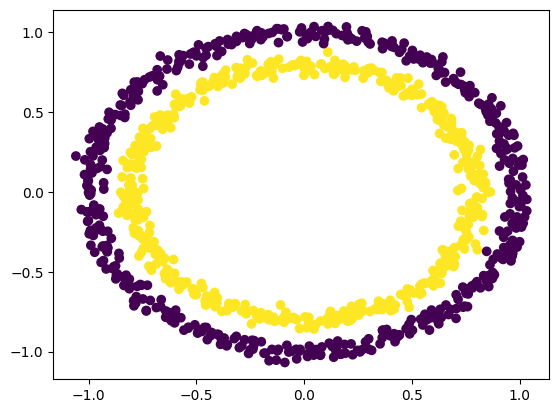

In [5]:
plt.scatter(x=X[:, 0], y=X[:, 1], c=y)

In [20]:
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32).unsqueeze(-1)

train_split = 0.8


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_split, random_state=42)

type(X_train), y.shape

TypeError: expected np.ndarray (got Tensor)

In [7]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [21]:
class BinaryClassifier(nn.Module):
    def __init__(self,):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(2,16),
            nn.ReLU(),
            nn.Linear(16,1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        return self.seq(x)


model = BinaryClassifier().to(device)
next(model.parameters()).device

device(type='cuda', index=0)

In [22]:
def save_state(save_path: Path, model: nn.Module, optim: torch.optim.Optimizer, epoch: int):
    model_state = model.state_dict()
    optim_state = optim.state_dict()
    state_dict = {
        'epoch': epoch,
        'model_state': model_state,
        'optim_state': optim_state,
    }
    torch.save(state_dict, save_path)
    print(f'Epoch {epoch}: States saved.')

In [23]:
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()

In [24]:
def train(
    model: nn.Module,
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_val: torch.Tensor,
    y_val: torch.Tensor,
    num_epochs: int,
    save_path: Path,
):
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_val = X_val.to(device)
    y_val = y_val.to(device)
    
    epochs = []
    losses = []
    accs = []
    val_losses = []
    val_accs = []
    
    for epoch in range(num_epochs):
        model.train()
        y_preds = model(X_train)
        loss = loss_fn(y_preds, y_train)
        y_preds = (y_preds > 0.5).type(torch.float32)
        train_acc = accuracy_score(y_train.cpu().numpy(), y_preds.cpu().numpy())
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        
        model.eval()
        with torch.inference_mode():
            y_preds_val = model(X_val)
            val_loss = loss_fn(y_preds_val, y_val)
            y_preds_val = (y_preds_val > 0.5).type(torch.float32)
            # print(y_preds_val[:2])
            val_acc = accuracy_score(y_val.cpu().numpy(), y_preds_val.cpu().numpy())
        
        if epoch % 25 == 0:
            # print(val_loss.cpu().numpy(), np.min(val_losses))
            if len(val_losses) == 0 or val_loss.cpu().numpy() < np.min(val_losses):
                save_state(save_path, model, optim, epoch)
        
            epochs.append(epoch)
            losses.append(loss.detach().cpu().numpy())
            accs.append(train_acc)
            
            val_losses.append(val_loss.detach().cpu().numpy())
            val_accs.append(val_acc)
            
            
            print(f'Epoch {epoch}/{num_epochs}:')
            print(f'loss: {loss:0.4f}\tacc: {train_acc:0.4f}\tval_loss: {val_loss:0.4f}\tval_acc: {val_acc:0.4f}')
            

In [25]:
X_train.shape, y_train.shape

(torch.Size([800, 2]), torch.Size([800, 1]))

In [26]:
num_epochs = 1500

save_dir = Path('models')
save_path = save_dir / 'simple_binary_classifier.pth'


train(model, X_train, y_train, X_test, y_test, num_epochs, save_path)

Epoch 0: States saved.
Epoch 0/1500:
loss: 0.6900	acc: 0.5300	val_loss: 0.6966	val_acc: 0.4900
Epoch 25: States saved.
Epoch 25/1500:
loss: 0.6865	acc: 0.5188	val_loss: 0.6927	val_acc: 0.4950
Epoch 50: States saved.
Epoch 50/1500:
loss: 0.6837	acc: 0.5375	val_loss: 0.6897	val_acc: 0.4950
Epoch 75: States saved.
Epoch 75/1500:
loss: 0.6809	acc: 0.5500	val_loss: 0.6874	val_acc: 0.4950
Epoch 100: States saved.
Epoch 100/1500:
loss: 0.6778	acc: 0.5500	val_loss: 0.6850	val_acc: 0.5100
Epoch 125: States saved.
Epoch 125/1500:
loss: 0.6745	acc: 0.5587	val_loss: 0.6825	val_acc: 0.5150
Epoch 150: States saved.
Epoch 150/1500:
loss: 0.6711	acc: 0.5613	val_loss: 0.6797	val_acc: 0.5200
Epoch 175: States saved.
Epoch 175/1500:
loss: 0.6673	acc: 0.5625	val_loss: 0.6766	val_acc: 0.5150
Epoch 200: States saved.
Epoch 200/1500:
loss: 0.6631	acc: 0.5938	val_loss: 0.6733	val_acc: 0.5450
Epoch 225: States saved.
Epoch 225/1500:
loss: 0.6585	acc: 0.6388	val_loss: 0.6694	val_acc: 0.6000
Epoch 250: States sa

In [53]:
model.eval()
with torch.inference_mode():
    yp = model(X_test.to(device)).cpu().numpy()
    # yp = (yp > 0.5).astype(np.float32)
    

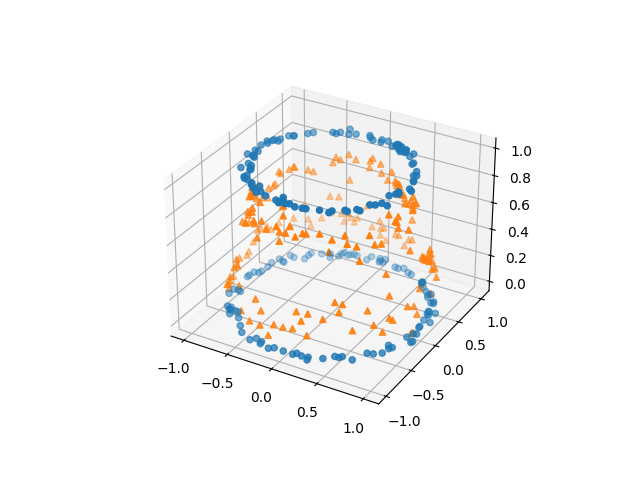

In [54]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(X_test[:, 0], X_test[:, 1], y_test, marker='o')
ax.scatter(X_test[:, 0], X_test[:, 1], yp, marker='^')